# Week 5: Pairs Trading Implementation

### Pairs Trading: Economic Intuition
- Given some collection of assets, there's a good chance that there might be some mutual correlation between them. Usually this is the result of one of the following:
    - They belong to the same sector (ie tech companies, auto, ect)
    - They are both large index funds (SPY, QQQ, ect)
    - Something more minute
- If these assets are correlated, then we can buy/sell shares of both companies whenever there is a divergence in their prices (we're betting on a mean reversion).
- It's generally a very stable strategy.  We call it **market neutral** since we're not just going long or short on an asset.

Let's take two well known assets and see if we think there exists a strong correlation.
- In this example we'll use SPY and QQQ.
    - SPY is an index fund comprising of the S&P 500 companies.
    - QQQ is an index fund comprising of the NASDAQ 100 companies.  
        - these are both large funds exposed to a lot of the US market, so it would be wise to expect correlation.

In [8]:
from setup_requests import get_historical_data, make_dataframe
from config import HEADERS

spy = make_dataframe(get_historical_data("minute", "SPY", 300, '2020-01-01', '2020-12-31'), "SPY")["c"]
qqq = make_dataframe(get_historical_data("minute", "QQQ", 300, '2020-01-01', '2020-12-31'), "QQQ")["c"]
# we'll just take the closing price for each day
spy.name = "SPY"
qqq.name = "QQQ"
print(spy)
print(qqq)

0      371.77
1      371.74
2      371.70
3      371.71
4      371.60
        ...  
295    374.10
296    374.26
297    374.23
298    374.30
299    374.41
Name: SPY, Length: 300, dtype: float64
0      312.795
1      312.850
2      312.820
3      312.800
4      312.930
        ...   
295    313.820
296    313.820
297    313.810
298    313.960
299    313.970
Name: QQQ, Length: 300, dtype: float64


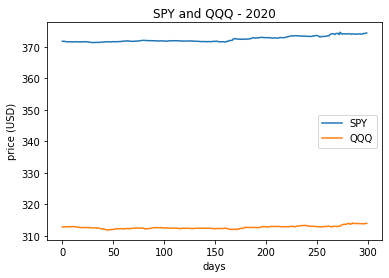

In [9]:
import matplotlib.pyplot as plt

plt.plot(spy, label=spy.name)
plt.plot(qqq, label=qqq.name)
plt.xlabel("days")
plt.ylabel("price (USD)")
plt.title("SPY and QQQ - 2020")
plt.legend()
plt.show()

We can clearly see a very strong corellation between these two assets.  They share a lot of the same movement.

We'll use the techniques from last week to develop a pairs trading strategy.

Luckily for us there's a single function we can use to test if these two time series's are cointegrated.

In [16]:
from statsmodels.tsa.stattools import coint # test cointegration - H0: no cointegration

def is_cointegrated(series1, series2, significance=.01):
    # assumes series 1 and 2 are I(1)
    _, p_value, _ = coint(series1, series2)
    if p_value < significance:
        return True
    return False

is_cointegrated(spy, qqq)

False

Interesting, so even though it looks like there should be cointegration, the test does not confirm our hypothesis.
Maybe we should check a different timeframe, since oftentimes assets might be not cointegrated on one time scale, yet cointegrated on a different scale.  

In [17]:
spy = make_dataframe(get_historical_data("minute", "SPY", 1000, '2020-01-01', '2020-12-31'), "SPY")["o"]
qqq = make_dataframe(get_historical_data("minute", "QQQ", 1000, '2020-01-01', '2020-12-31'), "QQQ")["o"]
# we'll just take the closing price for each day
spy.name = "SPY"
qqq.name = "QQQ"
print(spy)
print(qqq)

0      370.90
1      370.99
2      371.12
3      371.37
4      371.32
        ...  
995    374.10
996    374.28
997    374.23
998    374.30
999    374.41
Name: SPY, Length: 1000, dtype: float64
0      312.94
1      313.02
2      312.93
3      312.98
4      313.06
        ...  
995    313.82
996    313.83
997    313.81
998    313.96
999    313.97
Name: QQQ, Length: 1000, dtype: float64


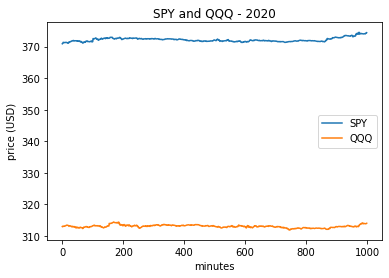

In [18]:
plt.plot(spy, label=spy.name)
plt.plot(qqq, label=qqq.name)
plt.xlabel("minutes")
plt.ylabel("price (USD)")
plt.title("SPY and QQQ - 2020")
plt.legend()
plt.show()

This also doesn't pass our test.  This illustrates an improtant idea, we can't just trust pictures.  

In [28]:
def find_coint_pairs(stocks: list):
    pairs = []
    for asset1 in stocks:
        for asset2 in stocks:
            price1 = make_dataframe(get_historical_data("day", asset1, 300, '2020-01-01', '2020-12-31'), asset1)["c"]
            price2 = make_dataframe(get_historical_data("day", asset2, 300, '2020-01-01', '2020-12-31'), asset2)["c"]
            if asset1 is not asset2 and is_cointegrated(price1, price2):
                    pairs.append([asset1, asset2])
    return pairs             

In [29]:
find_coint_pairs(["AAPL", "JPM", "TWTR", "F", "TSLA", "PG", "V", "WMT", "KO", "HD", "NKE"])

[['TWTR', 'NKE'], ['NKE', 'TWTR']]

In [30]:
nke = make_dataframe(get_historical_data("day", "NKE", 300, '2020-01-01', '2020-12-31'), "NKE")["c"]
twtr = make_dataframe(get_historical_data("day", "TWTR", 300, '2020-01-01', '2020-12-31'), "TWTR")["c"]
nke.name = "NKE"
twtr.name = "TWTR"

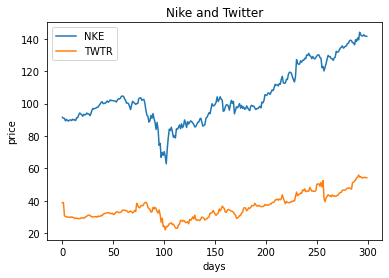

In [31]:
plt.plot(nke, label=nke.name)
plt.plot(twtr, label=twtr.name)
plt.xlabel("days")
plt.ylabel("price")
plt.title("Nike and Twitter")
plt.legend()
plt.show()

These look pretty good, and now we have proper statistical reasoning behind why our pair should work.
In reality we could do something crazy like feeding the entire S&P 500 into this function, but what we would likely end up with is a lot of pairs that are controlled by some confounding variable that is actually what is moving the pair.  Whenever we're doing statarb, we want our bet to be about the stock's were trading only and not some third variable.  This is why targeted approaches to something like finding cointegrated pairs is very important.

Now that we have our pair, we can focus on generating our alpha coefficient.  

In [38]:
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant

def estimate_coef(series1, series2, window=30):  # inputs are X, Y
    series1.name = "slope"
    series1 = add_constant(series1)
    combination = RollingOLS(series2, series1, window=window).fit()  # in form (dependent, independent)
    # Need rolling OLS to prevent look ahead bias - guarenttes we're only predicting beta using values we already know
    # const is not important since it just shifts mean to 0.  
    return combination.params["slope"]
    
alpha = estimate_coef(nke, twtr)

Rolling regression is important because we don't want our $\alpha$ to depend on values in the future, which we would not yet know.
- Instead, our $\alpha$ depends on the past 30 days.
- We may get different results in backtests based on what window length we choose, but we should be careful because this is likely going to lead to overfitting.  


In [40]:
import numpy as np
spread = np.array(twtr) - alpha * np.array(nke)
spread.name = "spread"
spread

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
295   -72.324016
296   -81.996960
297   -90.669448
298   -99.599787
299   -97.798952
Name: spread, Length: 300, dtype: float64

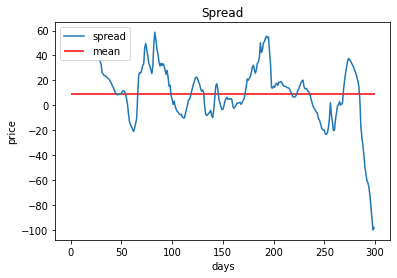

In [42]:
plt.plot(spread, label=spread.name)
plt.hlines(spread.mean(), 0,  len(spread), colors="red", label="mean")
plt.xlabel("days")
plt.ylabel("price")
plt.title("Spread")
plt.legend()
plt.show()

What we've done here is created a derivative, whose price is $T_i - \alpha S_i$
- We can go **go long the spread** when the above is sufficiently small
- We'll can go **go short the spread** when the above is sufficiently large

- What we notice is that this price is **mean reverting**.  When it's large or small, it tends to go back to the mean.  We can use this belief to make bets on a mean reversion whenever we sufficiently diverge.

- If this price is large, then $T_i >> \alpha S_i$, so we would expect $T_i$ to decrease and $S_i$ to increase.
    - Thus, we can short $T_i$ and long $\alpha$ units of $S_i$.  This is a very secure investment since we're equally esposed to the market.
- If this price is small, then $T_i << \alpha S_i$, so we would expect $T_i$ to increase and $S_i$ to decrease.
    - Thus, we can buy $T_i$ and short $\alpha$ units of $S_i$.  
- Once our price goes back towards the mean, we can dump our shares for a solid profit.  

- A very important thing to do, however, is always check whether our cointegration relationship still exists.  We can notice a very large divergence in the above plot around 300, so this might be an indication that our relationship is weakening.
    - If we wanted to trade this strategy, we would want tons of pairs that we're tracking since at any given point a pair might fail to be cointegrated, in which case we'd want to replace it with another pair.